En la tarea hacemos uso de los modelos recurrentes usando las capas LSTM, RNN y GRU para la predicción de consumo de energía del Hogar. Es decir, damos una predicción en base a las series de datos de consumo de energía proporcionados 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import os 
import pandas as pd
import sys 
import numpy as np 
from scipy.stats import randint
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import GRU, Dense

Leemos los datos y los asignamos a la variable "df"

In [ ]:
df = pd.read_csv('/content/household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

Comprobamos que los datos se ingresaron correctamente 

In [ ]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

Comprobamos que columnas tienen datos nulos (en este caso todas ellas los contienen)

In [ ]:
droping_list_all=[]  
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

Cambiamos los datos nulos por la media de la media de la columna 

In [ ]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

Comprobamos que ya no existen los NULL 

In [ ]:
for j in range(0,7):
  print(df.iloc[:, j].notnull().all())

True
True
True
True
True
True
True


Creamos la función que toma la serie temporal de datos y la transforma a un conjunto de datos supervisados 

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] #determinamos la 
    #cantidad de variables, si el parametro de datos es una lista lo asig-
    #namos a 1, de lo contrario a la cantidad de columnas. 
    dff = pd.DataFrame(data) #Creamos el Data Frame a partir de los datos
    #de entrada 
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        #Agregamos a "cols" una columna desplazada en "i" hacia arriba 
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        #Agregamos a "cols" una columna desplazada en "i" hacia abajo 
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True) #Quitamos todos los NULL que quedaron de
            #los desplazamientos. 
        return agg

In [ ]:
#Dado que son muchos datos los agrupamos por horas con la media, es decir 
#cada día tiene 24 medidas y cada medida es la media de los datos durante esa 
#hora 
df_resample = df.resample('h').mean()
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [ ]:
#Observamos la diferencia de datos
print(df_resample.shape)
print(df.shape)

(34589, 7)
(2075259, 7)


In [ ]:
#Pasamos los datos a un arreglo y los normalizamos 
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.63681623 0.29573827 0.33794529 ... 0.         0.01136636 0.78241815]
 [0.54504495 0.10335773 0.33550078 ... 0.         0.14465183 0.78267595]
 [0.50900588 0.11007318 0.28380167 ... 0.         0.03086863 0.7741686 ]
 ...
 [0.2385342  0.07752906 0.41839455 ... 0.         0.00143575 0.        ]
 [0.16153105 0.07899268 0.52024552 ... 0.         0.022972   0.        ]
 [0.12594772 0.         0.53152393 ... 0.         0.         0.        ]]


In [ ]:
reframed = series_to_supervised(scaled, 1, 1) 
print(reframed)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
0       0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
1       0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
2       0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
3       0.455597   0.099010   0.434417   0.449904        0.0   0.008973   
4       0.322555   0.072536   0.495847   0.323529        0.0   0.002872   
...          ...        ...        ...        ...        ...        ...   
34583   0.248876   0.079294   0.431003   0.240794        0.0   0.000000   
34584   0.225194   0.069350   0.448732   0.219393        0.0   0.000000   
34585   0.238534   0.077529   0.418395   0.235055        0.0   0.001436   
34586   0.161531   0.078993   0.520246   0.158178        0.0   0.022972   
34587   0.125948   0.000000   0.531524   0.118245        0.0   0.000000   

       var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)  var5(t)   var6(t)  \
0       0.782676  0.

En las dos anteriores celdas podemos ver la diferencia de la base de datos después de aplicar nuestra función. 

In [ ]:
values = reframed.values 
n_train_time = 365*24 #Establecemos el número de registros a utilizar para el
#entrenamiento del modelo. En este caso, se utiliza un año de datos, 
#donde cada dia tiene 24 registros
train = values[:n_train_time, :] #tomamos el primer año de los datos
#para entrenar 
test = values[n_train_time:, :] #Tomamos el resto de filas para prueba
train_x, train_y = train[:, :-1], train[:, -1] #Tomamos la última columna como
#etiquetas 
test_x, test_y = test[:, :-1], test[:, -1] #Lo mismo pero con el conjunto de 
#prueba 
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1])) #Agregamos 
#una dimensión adicional para indicar el tamaño de lote 
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/20
126/126 - 7s - loss: 0.0192 - val_loss: 0.0116 - 7s/epoch - 56ms/step
Epoch 2/20
126/126 - 2s - loss: 0.0122 - val_loss: 0.0107 - 2s/epoch - 12ms/step
Epoch 3/20
126/126 - 2s - loss: 0.0118 - val_loss: 0.0101 - 2s/epoch - 12ms/step
Epoch 4/20
126/126 - 2s - loss: 0.0113 - val_loss: 0.0098 - 2s/epoch - 15ms/step
Epoch 5/20
126/126 - 2s - loss: 0.0111 - val_loss: 0.0095 - 2s/epoch - 15ms/step
Epoch 6/20
126/126 - 2s - loss: 0.0110 - val_loss: 0.0095 - 2s/epoch - 17ms/step
Epoch 7/20
126/126 - 2s - loss: 0.0110 - val_loss: 0.0094 - 2s/epoch - 15ms/step
Epoch 8/20
126/126 - 2s - loss: 0.0110 - val_loss: 0.0096 - 2s/epoch - 15ms/step
Epoch 9/20
126/126 - 2s - loss: 0.0108 - val_loss: 0.0095 - 2s/epoch - 15ms/step
Epoch 10/20
126/126 - 2s - loss: 0.0109 - val_loss: 0.0096 - 2s/epoch - 15ms/step
Epoch 11/20
126/126 - 2s - loss: 0.0108 - val_loss: 0.0095 - 2s/epoch - 15ms/step
Epoch 12/20
126/126 - 3s - loss: 0.0109 - val_loss: 0.0096 - 3s/epoch - 27ms/step
Epoch 13/20
126/126 - 2s 

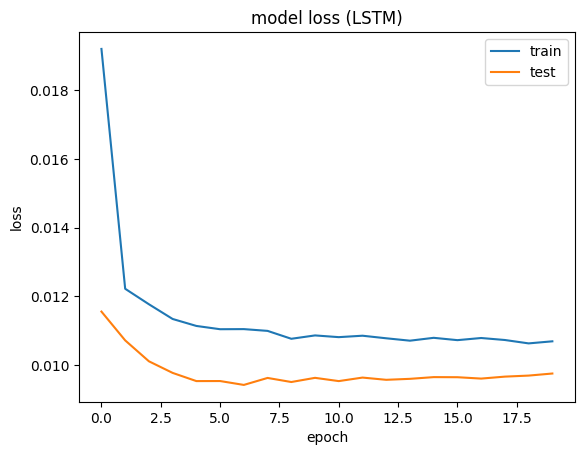

808/808 [==============================] - 2s 2ms/step
Test RMSE: 0.636


In [ ]:
model = Sequential() #Creanos un objeto de modelo secuencial 
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))#Agregamos
#una capa LSTM al modelo 
model.add(Dropout(0.2))#Agregamos una capa Dropout para evitar el sobreajuste 
model.add(Dense(1))#Agrega una capa densa de salida 
model.compile(loss='mean_squared_error', optimizer='adam')#Compilamos el modelo
#Entrenamos el modelo 
history = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Gráficamos la curva de perdida 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Realizamos una predicción utilizando el conjunto de prueba 
yhat = model.predict(test_x)
#Regresamos a la forma original de los datos 
test_x_pred = test_x.reshape((test_x.shape[0], 7))
# Combinamos las predicciones con las últimas 6 columnas de prueba 
inv_yhat = np.concatenate((yhat, test_x_pred[:, -6:]), axis=1)
#invertimos la escala 
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y_pred = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_pred, test_x_pred[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculamos RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

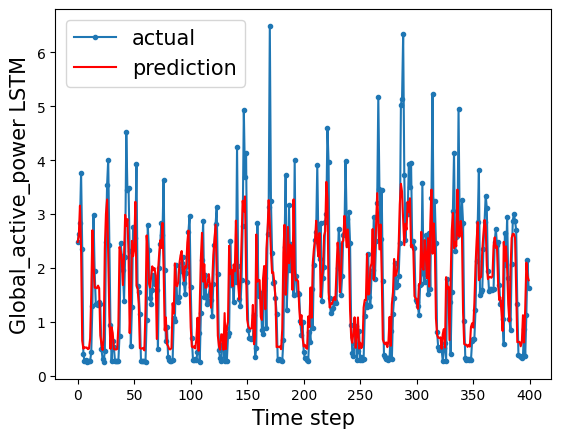

In [ ]:
aa=[x for x in range(400)]
plt.plot(aa, inv_y[:400], marker='.', label="actual")
plt.plot(aa, inv_yhat[:400], 'r', label="prediction")
plt.ylabel('Global_active_power LSTM', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Vemos los siguientes dos modelos. 

Epoch 1/50
274/274 - 4s - loss: 0.0128 - val_loss: 0.0093 - 4s/epoch - 16ms/step
Epoch 2/50
274/274 - 3s - loss: 0.0112 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 3/50
274/274 - 3s - loss: 0.0112 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 4/50
274/274 - 3s - loss: 0.0112 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 5/50
274/274 - 3s - loss: 0.0112 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 6/50
274/274 - 3s - loss: 0.0111 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 7/50
274/274 - 3s - loss: 0.0111 - val_loss: 0.0090 - 3s/epoch - 12ms/step
Epoch 8/50
274/274 - 4s - loss: 0.0111 - val_loss: 0.0091 - 4s/epoch - 14ms/step
Epoch 9/50
274/274 - 2s - loss: 0.0111 - val_loss: 0.0092 - 2s/epoch - 8ms/step
Epoch 10/50
274/274 - 3s - loss: 0.0111 - val_loss: 0.0093 - 3s/epoch - 12ms/step
Epoch 11/50
274/274 - 3s - loss: 0.0111 - val_loss: 0.0094 - 3s/epoch - 12ms/step
Epoch 12/50
274/274 - 4s - loss: 0.0111 - val_loss: 0.0095 - 4s/epoch - 14ms/step
Epoch 13/50
274/274 - 3s -

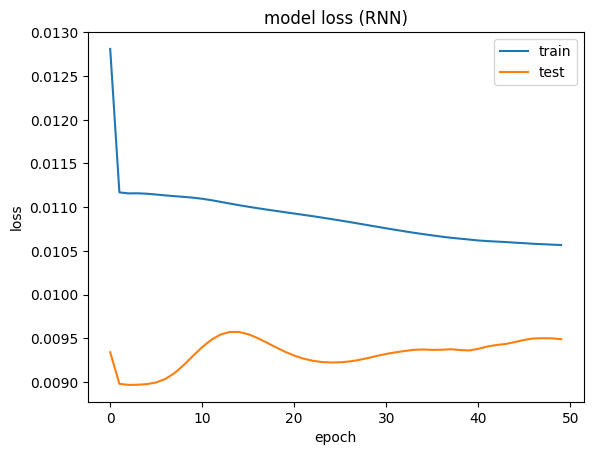

808/808 [==============================] - 2s 2ms/step
Test RMSE: 0.627


In [ ]:

model_1= Sequential()
model_1.add(SimpleRNN(200, input_shape=(train_x.shape[1], train_x.shape[2])))

model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model_1.fit(train_x, train_y, epochs=50, batch_size=32, validation_data=(test_x, test_y), verbose=2, shuffle=False)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss (RNN)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

yhat_RNN = model_1.predict(test_x)
test_x_pred_RNN = test_x.reshape((test_x.shape[0], 7))

inv_yhat_RNN = np.concatenate((yhat_RNN, test_x_pred_RNN[:, -6:]), axis=1)
inv_yhat_RNN = scaler.inverse_transform(inv_yhat_RNN)
inv_yhat_RNN = inv_yhat_RNN[:,0]

test_y_pred_RNN = test_y.reshape((len(test_y), 1))
inv_y_RNN = np.concatenate((test_y_pred_RNN, test_x_pred_RNN[:, -6:]), axis=1)
inv_y_RNN = scaler.inverse_transform(inv_y_RNN)
inv_y_RNN = inv_y_RNN[:,0]

rmse = np.sqrt(mean_squared_error(inv_y_RNN, inv_yhat_RNN))
print('Test RMSE: %.3f' % rmse)

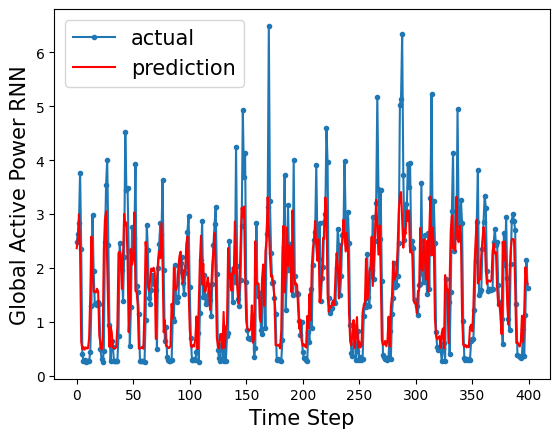

In [ ]:
aa_RNN=[x for x in range(400)]
plt.plot(aa_RNN, inv_y_RNN[:400], marker='.', label="actual")
plt.plot(aa_RNN, inv_yhat_RNN[:400], 'r', label="prediction")
plt.ylabel('Global Active Power RNN', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

Epoch 1/35
274/274 - 13s - loss: 0.0137 - val_loss: 0.0100 - 13s/epoch - 48ms/step
Epoch 2/35
274/274 - 7s - loss: 0.0111 - val_loss: 0.0096 - 7s/epoch - 26ms/step
Epoch 3/35
274/274 - 6s - loss: 0.0110 - val_loss: 0.0095 - 6s/epoch - 23ms/step
Epoch 4/35
274/274 - 9s - loss: 0.0109 - val_loss: 0.0095 - 9s/epoch - 34ms/step
Epoch 5/35
274/274 - 7s - loss: 0.0109 - val_loss: 0.0095 - 7s/epoch - 26ms/step
Epoch 6/35
274/274 - 6s - loss: 0.0108 - val_loss: 0.0095 - 6s/epoch - 23ms/step
Epoch 7/35
274/274 - 7s - loss: 0.0108 - val_loss: 0.0095 - 7s/epoch - 26ms/step
Epoch 8/35
274/274 - 6s - loss: 0.0107 - val_loss: 0.0095 - 6s/epoch - 23ms/step
Epoch 9/35
274/274 - 7s - loss: 0.0107 - val_loss: 0.0094 - 7s/epoch - 26ms/step
Epoch 10/35
274/274 - 6s - loss: 0.0106 - val_loss: 0.0094 - 6s/epoch - 23ms/step
Epoch 11/35
274/274 - 9s - loss: 0.0106 - val_loss: 0.0094 - 9s/epoch - 32ms/step
Epoch 12/35
274/274 - 6s - loss: 0.0106 - val_loss: 0.0094 - 6s/epoch - 23ms/step
Epoch 13/35
274/274 - 9

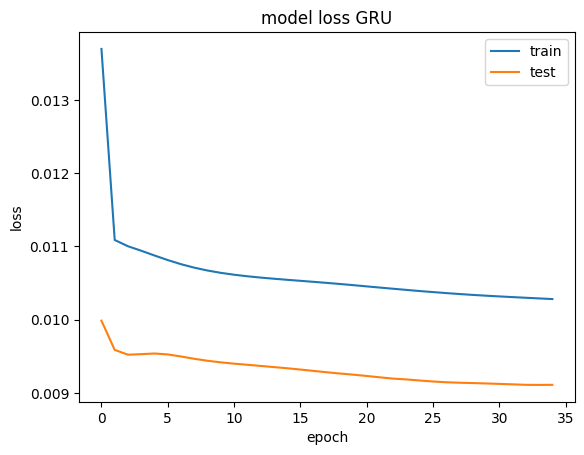

808/808 [==============================] - 6s 5ms/step
Test RMSE: 0.614


In [ ]:
model_2= Sequential()
model_2.add(GRU(400, input_shape=(train_x.shape[1], train_x.shape[2])))

model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model_2.fit(train_x, train_y, epochs=35, batch_size=32, validation_data=(test_x, test_y), verbose=2, shuffle=False)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

yhat_GRU = model_2.predict(test_x)
test_x_pred_GRU = test_x.reshape((test_x.shape[0], 7))

inv_yhat_GRU = np.concatenate((yhat_GRU, test_x_pred_GRU[:, -6:]), axis=1)
inv_yhat_GRU = scaler.inverse_transform(inv_yhat_GRU)
inv_yhat_GRU = inv_yhat_GRU[:,0]

test_y_pred_GRU = test_y.reshape((len(test_y), 1))
inv_y_GRU = np.concatenate((test_y_pred_GRU, test_x_pred_GRU[:, -6:]), axis=1)
inv_y_GRU = scaler.inverse_transform(inv_y_GRU)
inv_y_GRU = inv_y_GRU[:,0]

rmse = np.sqrt(mean_squared_error(inv_y_GRU, inv_yhat_GRU))
print('Test RMSE: %.3f' % rmse)

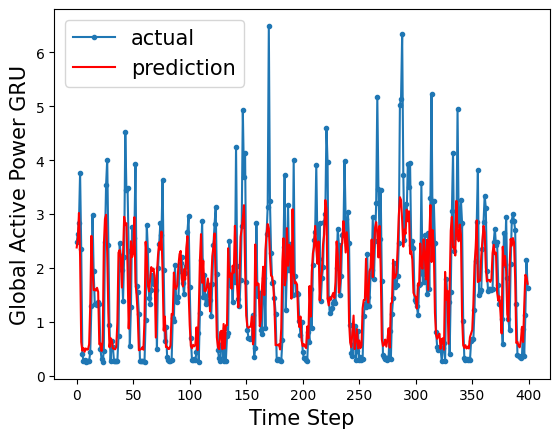

In [ ]:
aa_GRU=[x for x in range(400)]
plt.plot(aa_GRU, inv_y_GRU[:400], marker='.', label="actual")
plt.plot(aa_GRU, inv_yhat_GRU[:400], 'r', label="prediction")
plt.ylabel('Global Active Power GRU', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
print(yhat_GRU)
print(test_y)
#print(yhat_RNN)
#print(yhat)

[[0.35066938]
 [0.37623796]
 [0.45002964]
 ...
 [0.2330867 ]
 [0.17681476]
 [0.13541812]]
[0.36525355 0.38881696 0.42106517 ... 0.22519369 0.2385342  0.16153105]


Gráfica de dispersión para el modelo LSTM

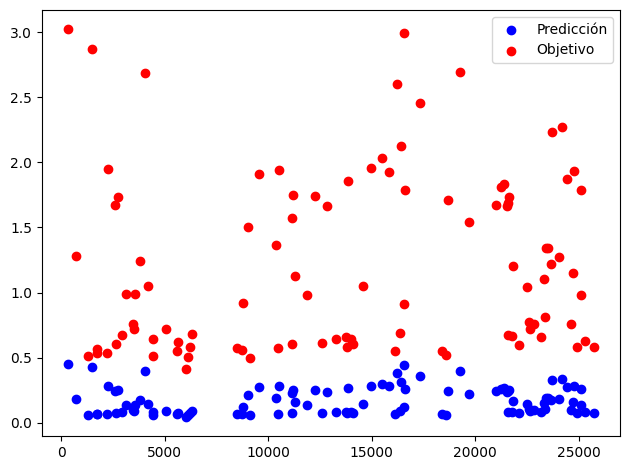

In [ ]:
indices = np.random.choice(range(len(test_y)), size=100, replace=False)

valores_pred = yhat[indices]
valores_test = inv_yhat[indices]
plt.scatter(indices, valores_pred, label='Predicción', marker='o', color='blue')
plt.scatter(indices, valores_test, label='Objetivo', marker='o', color='red')
plt.legend()
plt.tight_layout()
plt.show()

Gráfica de dispersión para el modelo RNN

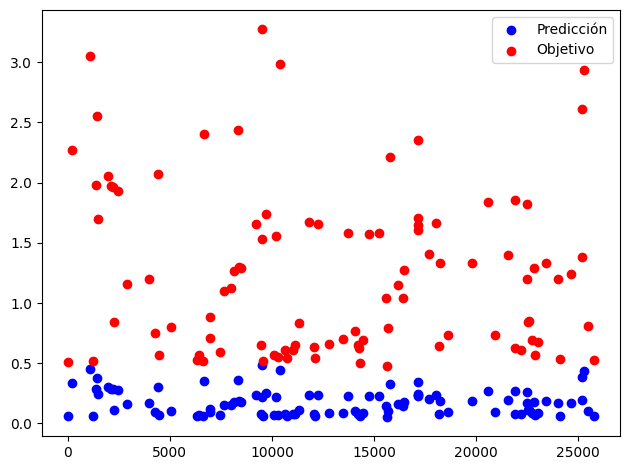

In [ ]:
indices = np.random.choice(range(len(test_y)), size=100, replace=False)

valores_pred = yhat_RNN[indices]
valores_test = inv_yhat_RNN[indices]
plt.scatter(indices, valores_pred, label='Predicción', marker='o', color='blue')
plt.scatter(indices, valores_test, label='Objetivo', marker='o', color='red')
plt.legend()
plt.tight_layout()
plt.show()

Gráfica de dispersión para el modelo GRU

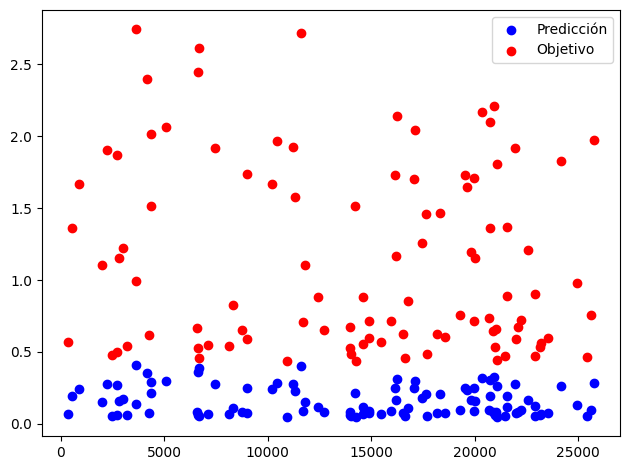

In [ ]:
indices = np.random.choice(range(len(test_y)), size=100, replace=False)

valores_pred = yhat_GRU[indices]
valores_test = inv_yhat_GRU[indices]
plt.scatter(indices, valores_pred, label='Predicción', marker='o', color='blue')
plt.scatter(indices, valores_test, label='Objetivo', marker='o', color='red')
plt.legend()
plt.tight_layout()
plt.show()

De las gráficas de predicción podemos notar que los 3 modelos dan predicciones muy similares. 
En las curvas de perdida observamos que el modelo con capa LSTM se comporta mejor que los otros dos modelos. 
Las gráficas de dispersión nos muestran de una manera más clara que que ninguno de los modelos se ajusta de una manera satisfactoria